In [1]:
import math
import pandas as pd
import numpy as np
# Prob_size, new_Capacity = 5, 10
inputfilepath='cr_inventoryRouter.txt'


import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from matplotlib.pyplot import cm
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')


In [2]:
def compute_distance_matrix(customers_x, customers_y):
    nb_customers = len(customers_x)
    distance_matrix = [[None for _ in range(nb_customers)] for _ in range(nb_customers)]
    for i in range(nb_customers):
        distance_matrix[i][i] = 0
        for j in range(nb_customers):
            dist = compute_dist(customers_x[i], customers_x[j], customers_y[i], customers_y[j])
            distance_matrix[i][j] = dist
            distance_matrix[j][i] = dist
    return distance_matrix

def compute_dist(xi, xj, yi, yj):
    exact_dist = math.sqrt(math.pow(xi - xj, 2) + math.pow(yi - yj, 2))
#     return int(math.floor(exact_dist + 0.5))
    return np.round(exact_dist,2)

# Computes the distances to warehouse
def compute_distance_warehouses(depot_x, depot_y, customers_x, customers_y):
    nb_customers = len(customers_x)
    distance_warehouses = [None] * nb_customers
    for i in range(nb_customers):
        dist = compute_dist(depot_x, customers_x[i], depot_y, customers_y[i])
        distance_warehouses[i] = dist
    return distance_warehouses

def read_elem(filename):
    with open(filename ,'r') as f:
        return [str(elem) for elem in f.read().split()]


def read_input_sdvrp(filename):
    file_it = iter(read_elem(filename))
    nb_customers = int(next(file_it))
    capacity = int(next(file_it))
    demands = [None] * nb_customers
    for i in range(nb_customers):
        demands[i] = int(next(file_it))

    # Extracting the coordinates of the warehouse and the customers
    customers_x = [None] * nb_customers
    customers_y = [None] * nb_customers
    depot_x = float(next(file_it))
    depot_y = float(next(file_it))
    for i in range(nb_customers):
        customers_x[i] = float(next(file_it))
        customers_y[i] = float(next(file_it))
    
    distance_matrix = compute_distance_matrix(customers_x, customers_y)
    distance_warehouses = compute_distance_warehouses(depot_x, depot_y, customers_x, customers_y)
    return nb_customers, capacity, distance_matrix, distance_warehouses, demands, customers_x, customers_y, depot_x, depot_y

In [3]:
def truck_path(t_id,result_df):
  result        = result_df
  truck_result  = result[result['Vehicle']  ==  t_id].copy()

  i   = 0
  f   = 0

  print('Route for truck ',t_id," is:")
  print("0 --> ", end = "")

  while(i < len(truck_result)-1):
    start   = truck_result[truck_result['start']  ==  f]['start']
    end     = truck_result[truck_result['start']  ==  f]['end']
    demand  = truck_result[truck_result['start']  ==  f]['Demand']

    print("{end}({demand}) --> ".format(end = int(end), demand = int(demand)), end  = " ")

    i = i + 1
    f = int(end)
  print(0, end="\n\n")



def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color),
        size=size
    )


def truck_map(t_id,result_df,corrdinates,colors):
  result        = result_df
  truck_result  = result[result['Vehicle']  ==  t_id].copy()

  truck_num     = "Truck {}".format(t_id)

  i   = 0
  f   = 0

  while(i < len(truck_result)-1):
    start   = truck_result[truck_result['start']  ==  f]['start'].values[0]
    end     = truck_result[truck_result['start']  ==  f]['end'].values[0]
    demand  = truck_result[truck_result['start']  ==  f]['Demand'].values[0]

    x_start = corrdinates[corrdinates['Store']  ==  start]['X'].values[0]
    y_start = corrdinates[corrdinates['Store']  ==  start]['Y'].values[0]
    x_end   = corrdinates[corrdinates['Store']  ==  end]['X'].values[0]
    y_end   = corrdinates[corrdinates['Store']  ==  end]['Y'].values[0]

    plt.scatter([x_start,x_end],[y_start,y_end], s =70, c=colors)
    plt.annotate(str(end), (x_end, y_end),fontsize = 12)
    line = plt.plot([x_start,x_end],[y_start,y_end],c=colors)[0]


    

    add_arrow(line)

    # plt.show()
    i = i + 1
    f = int(end)


def result_path(result):
  result_in = result
  for i in result.Vehicle.unique():
    truck_path(i,result_in)


def results(result_op,corrdinates):
  result = result_op
  n_vehicles = result['Vehicle'].nunique()

  plt.figure(figsize=(10,10))
  # fig, ax = plt.subplots()
  plt.annotate("Warehouse", (40, 40))
  color = cm.rainbow(np.linspace(0, 1, n_vehicles))
  for i, c in zip(result['Vehicle'].unique(), color):
    truck_map(i,result,corrdinates,c)
    # custom_lines = [Line2D([0], [0], color=c, lw=4)]
    # plt.legend(custom_lines, str(i))
  result_path(result_op)

In [4]:
def Decrease_Problem_size(n_customers, Capacity, Distance_Matrix, Distance_Warehouses, Demands,  customers_x, customers_y, size, new_capacity):
    n_customers = size 
    Capacity = new_capacity
    Distance_Matrix = [[Distance_Matrix[i][j] for i in range(size)]for j in range(size)]
    Distance_Warehouses = Distance_Warehouses[:size]
    Demands = Demands[:size]
    customers_x = customers_x[:size]
    customers_y = customers_y[:size]
    return (n_customers, Capacity, Distance_Matrix, Distance_Warehouses, Demands,customers_x, customers_y)

# Approach 1 

## ortools + warm start with pulp model 

In [5]:
(n_customers, Capacity, Distance_Matrix, Distance_Warehouses, Demands,  customers_x, customers_y, depot_x, depot_y)=read_input_sdvrp(inputfilepath)
# (n_customers, Capacity, Distance_Matrix, Distance_Warehouses, Demands, customers_x, customers_y) = Decrease_Problem_size(n_customers, Capacity, Distance_Matrix, Distance_Warehouses, Demands, customers_x, customers_y ,
#                                                                                                Prob_size, new_Capacity)
    
    

In [6]:
df_data=pd.DataFrame([[depot_x]+customers_x, [depot_y]+customers_y, [0]+Demands ]).T

In [7]:
df_data.columns=['X','Y','Demand']
df_data.to_csv('corrdinate_demand_data.csv')
Distance_Matrix_ortools = compute_distance_matrix([depot_x]+customers_x, [depot_y]+customers_y)
pd.DataFrame(Distance_Matrix_ortools).to_csv('DistanceMatrix.csv')

In [8]:
Demands=[0]+Demands
customers_x=[depot_x]+customers_x
customers_y=[depot_y]+customers_y

In [9]:
IdentityDict={}
while max(Demands)>Capacity:
    Max_demand=max(Demands)
    i=Demands.index(max(Demands))
    Demands[i]=Capacity
    Demands.append(Max_demand-Capacity)
    IdentityDict[len(Demands)-1]=i
        

In [10]:
for i in IdentityDict.keys():
    customers_x.append(customers_x[int(IdentityDict[i])])
    customers_y.append(customers_y[int(IdentityDict[i])])
    

In [11]:
Distance_Matrix_ortools = compute_distance_matrix(customers_x, customers_y)


In [12]:
n_Vehicles = int(np.ceil(sum(Demands)/Capacity))

In [13]:
"""Capacited Vehicles Routing Problem (CVRP)."""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [14]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = Distance_Matrix_ortools
    data['demands'] = Demands
    data['vehicle_capacities'] = [Capacity]*n_Vehicles
    data['num_vehicles'] = n_Vehicles
    data['depot'] = 0
    return data
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    total_distance = 0
    total_load = 0
    routes={}
    loads={}
    for vehicle_id in range(data['num_vehicles']):
        route_vehicle_id=[]
        route_load_v=[]
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            route_vehicle_id.append(node_index)
            route_load_v.append(route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        routes[vehicle_id]=route_vehicle_id+[0]
        loads[vehicle_id]=route_load_v+[0]
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
#         print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))
    
    
    return(routes,loads)

In [15]:
"""Solve the CVRP problem."""
# Instantiate the data problem.
data = create_data_model()

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                       data['num_vehicles'], data['depot'])

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

# Create and register a transit callback.
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)


# Add Capacity constraint.
def demand_callback(from_index):
    """Returns the demand of the node."""
    # Convert from routing variable Index to demands NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(
    demand_callback)
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    data['vehicle_capacities'],  # vehicle maximum capacities
    True,  # start cumul to zero
    'Capacity')

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
search_parameters.time_limit.FromSeconds(1)

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)
# print(solution)

# Print solution on console.
if solution:
    Routes_start, Loads_start=print_solution(data, manager, routing, solution)

Assignment(Capacity0 (0) | Capacity1 (150) | Capacity2 (162) | Capacity3 (0) | Capacity4 (0) | Capacity5 (64) | Capacity6 (201) | Capacity7 (53) | Capacity8 (27) | Capacity9 (112) | Capacity10 (177) | Capacity11 (45) | Capacity12 (204) | Capacity13 (152) | Capacity14 (90) | Capacity15 (178) | Capacity16 (12) | Capacity17 (190) | Capacity18 (78) | Capacity19 (121) | Capacity20 (99) | Capacity21 (32) | Capacity22 (103) | Capacity23 (74) | Capacity24 (47) | Capacity25 (98) | Capacity26 (0) | Capacity27 (186) | Capacity28 (115) | Capacity29 (51) | Capacity30 (0) | Capacity31 (152) | Capacity32 (28) | Capacity33 (174) | Capacity34 (48) | Capacity35 (43) | Capacity36 (156) | Capacity37 (85) | Capacity38 (21) | Capacity39 (141) | Capacity40 (157) | Capacity41 (106) | Capacity42 (121) | Capacity43 (132) | Capacity44 (11) | Capacity45 (30) | Capacity46 (0) | Capacity47 (168) | Capacity48 (187) | Capacity49 (42) | Capacity50 (56) | Capacity51 (0) | Capacity52 (67) | Capacity53 (68) | Capacity54 

In [16]:
for route in Routes_start:
    for j in IdentityDict.keys():
        if j in Routes_start[route]:
            print(j)
            Routes_start[route][Routes_start[route].index(j)] = IdentityDict[j]

## Pulp Implementation

In [17]:
(n_customers, Capacity, Distance_Matrix, Distance_Warehouses, Demands,  customers_x, customers_y, depot_x, depot_y)=read_input_sdvrp(inputfilepath)
# (n_customers, Capacity, Distance_Matrix, Distance_Warehouses, Demands, customers_x, customers_y) = Decrease_Problem_size(n_customers, Capacity, Distance_Matrix, Distance_Warehouses, Demands, customers_x, customers_y ,
#                                                                                                Prob_size, new_Capacity)
    
    

In [18]:
# index 0 refers to warehouse and 1 to n_demands refer to demand points4
n_Demands=len(Demands)
DemandNodes = [i for i in range(1, len(Demands)+1)]
n_Trucks = int(np.ceil(sum(Demands)/Capacity))
Trucks = [i for i in range(1, n_Trucks+1)]
DemandDict = dict(zip(DemandNodes,Demands))
WarehouseDistDict = dict(zip(DemandNodes, Distance_Warehouses))


In [19]:
Distance_Dict = {}
for i in DemandNodes:
    Distance_Dict[i]={}
    for j in DemandNodes:
        Distance_Dict[i][j]=Distance_Matrix[i-1][j-1]

In [20]:
# Considering Node 0 as warehouse
TotalNodes = [0] + DemandNodes

In [21]:
from pulp import *

In [22]:
# Create the 'prob' variable to contain the problem data
prob = LpProblem("Split_Delivery_Vehicle_Routing_Problem", LpMinimize)

In [23]:
# Arc[i][j][k] 
Arcs = LpVariable.dicts("Arc", (TotalNodes,TotalNodes,Trucks), cat="Binary")

In [24]:
# Y[i][k]
Y = LpVariable.dicts("Y", (DemandNodes,Trucks), cat="Continous",  lowBound=0, upBound=Capacity)
U = LpVariable.dicts("U", (DemandNodes,Trucks), cat="Continous", lowBound=0, upBound=n_Demands)

In [25]:
# Objective to minimize the total distance travelled 
prob += (
    lpSum([Arcs[i][j][k] * Distance_Dict[i][j] for i in DemandNodes for j in DemandNodes for k in Trucks])
    +lpSum([Arcs[0][j][k] * WarehouseDistDict[j] for j in DemandNodes for k in Trucks])
    +lpSum([Arcs[i][0][k] * WarehouseDistDict[i] for i in DemandNodes for k in Trucks]),
    "Total_Distance_Travelled",
)

In [26]:
#Flow Constraint
for k in Trucks:
    for j in DemandNodes:
        prob += (
            lpSum([Arcs[i_1][j][k] for i_1 in TotalNodes]) == lpSum([Arcs[j][i_2][k] for i_2 in TotalNodes]),
            "Flow_Constraint_DemandNode_%s truck %s" % (j,k),
        )
for k in Trucks:
    for i in DemandNodes:
        for j in DemandNodes:
            if i!=j:
                prob += (
                    U[i][k] - U[j][k] + n_Demands * Arcs[i][j][k] <= n_Demands-1 ,
                    "Subtour Elimination %s %s %s" % (i,j,k),
                )

In [27]:
for k in Trucks:
    prob += (
        lpSum([Arcs[0][j][k] for j in TotalNodes]) == 1,
        "FromWarehouse_truck_%s" % k,
    )
for k in Trucks:
    prob += (
        lpSum([Arcs[i][0][k] for i in TotalNodes]) == 1,
        "ToWarehouseFrom_truck_%s" % k,
    )

In [28]:
for i in DemandNodes:
    prob += (
        lpSum([Y[i][k] for k in Trucks]) == DemandDict[i],
        "Demand_Constraint_for_%s" % i,
    )
for i in DemandNodes:
    for k in Trucks:
        prob += (
            lpSum([Arcs[i][i][k]]) == 0,
            "WaitingArcs_for_%s %s" % (i,k),
    )

In [29]:
for k in Trucks:
    prob += (
        lpSum([Y[i][k] for i in DemandNodes]) <= Capacity,
        "Capacity_Constraint_for_%s" % k,
    )

In [30]:
Big_M = 500
for k in Trucks:
    for i in DemandNodes:
        prob += (
            lpSum([Arcs[i][j][k] for j in TotalNodes]) * DemandDict[i]  >=  Y[i][k],
            "Relate_Arc_Y_Variable_forNode_%s_truck_%s" %(i, k),
        )

In [31]:

# warm start 
for k in Trucks:
#     print(Routes_start[k-1])
    route = Routes_start[k-1]
    for i in range(len(route)-1):
        
        Arcs[route[i]][route[i+1]][k].setInitialValue(1)
        if i in DemandNodes:
            Y[route[i]][k].setInitialValue(Loads_start[k-1][i])
            




In [32]:

def angle_between_vectors_degrees(u, v):
    """Return the angle between two vectors in any dimension space,
    in degrees."""
    return np.degrees(
        math.acos(np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))))

In [33]:
# for i in DemandNodes:
#     for j in DemandNodes :
#         if i!=j:
#             if angle_between_vectors_degrees((customers_x[i-1]-depot_x,customers_y[i-1]-depot_y),
#                                  (customers_x[j-1]-depot_x,customers_y[j-1]-depot_y))>120:
#                 prob += (
#                 lpSum([Arcs[i][j][k] for k in Trucks ]) ==  0,
#                 "AngleHeuristic_%s__%s" %(i, j),
#             )

In [34]:
prob.solve(pulp.PULP_CBC_CMD(msg=True,gapRel = 0.05,timeLimit = 300, warmStart=True))
    

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/anugulatarun/.local/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/1c301042ac3846d59b1614792f401f54-pulp.mps mips /tmp/1c301042ac3846d59b1614792f401f54-pulp.mst sec 300 ratio 0.05 timeMode elapsed branch printingOptions all solution /tmp/1c301042ac3846d59b1614792f401f54-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 40526 COLUMNS
At line 400180 RHS
At line 440702 BOUNDS
At line 482185 ENDATA
Problem MODEL has 40521 rows, 41482 columns and 238364 elements
Coin0008I MODEL read with 0 errors
opening mipstart file /tmp/1c301042ac3846d59b1614792f401f54-pulp.mst.
MIPStart values read for 41482 variables.
seconds was changed from 1e+100 to 300
ratioGap was changed from 0 to 0.05
Option for timeMode changed from cpu to elapsed
Continuous objective value is 485.49 - 0.24 seconds
Cgl0002I 525 variables fixed
Cgl0004I processed model has 399

1

In [35]:
Result_Arcs = []
routes = []
for k in Trucks:
    kthroute=[]
    print("--------------------------------------------------")
    for i in TotalNodes:
        for j in TotalNodes:
            
            
            if Arcs[i][j][k].value():
                
                print(Arcs[i][j][k].name,Arcs[i][j][k].value())
                kthroute.append((i,j))
                if j!=0:
                    Result_Arcs.append([k,i,j,Y[j][k].value()])
#                     print(Y[i][k].value())
                else:
                    Result_Arcs.append([k,i,j,0])
    routes.append(kthroute)
#             if Y[i][k].value():
#                 print(Y[i][k].value())


--------------------------------------------------
Arc_0_51_1 1.0
Arc_1_73_1 1.0
Arc_6_0_1 1.0
Arc_16_63_1 1.0
Arc_23_56_1 1.0
Arc_24_23_1 1.0
Arc_33_6_1 1.0
Arc_41_42_1 1.0
Arc_42_43_1 1.0
Arc_43_1_1 1.0
Arc_49_24_1 1.0
Arc_51_16_1 1.0
Arc_56_41_1 1.0
Arc_63_49_1 1.0
Arc_73_33_1 1.0
--------------------------------------------------
Arc_0_4_2 1.0
Arc_4_45_2 1.0
Arc_5_37_2 1.0
Arc_20_70_2 1.0
Arc_29_5_2 1.0
Arc_36_47_2 1.0
Arc_37_20_2 1.0
Arc_45_29_2 1.0
Arc_47_48_2 1.0
Arc_48_0_2 1.0
Arc_60_71_2 1.0
Arc_69_36_2 1.0
Arc_70_60_2 1.0
Arc_71_69_2 1.0
--------------------------------------------------
Arc_0_58_3 1.0
Arc_10_72_3 1.0
Arc_11_59_3 1.0
Arc_12_0_3 1.0
Arc_31_10_3 1.0
Arc_38_11_3 1.0
Arc_58_38_3 1.0
Arc_59_66_3 1.0
Arc_65_31_3 1.0
Arc_66_65_3 1.0
Arc_72_12_3 1.0
--------------------------------------------------
Arc_0_3_4 1.0
Arc_3_44_4 1.0
Arc_9_39_4 1.0
Arc_17_0_4 1.0
Arc_18_55_4 1.0
Arc_25_9_4 1.0
Arc_32_50_4 1.0
Arc_39_40_4 1.0
Arc_40_17_4 1.0
Arc_44_32_4 1.0
Arc_50_18_4 1.0


In [36]:
pd.DataFrame(Result_Arcs,columns=['Vehicle','start','end','Demand']).to_csv('Result_ortools_pulp_warmstart.csv')

In [37]:
corrdinates     = pd.read_csv("corrdinate_demand_data.csv")
result_pulp  = pd.read_csv("Result_ortools_pulp_warmstart.csv")

corrdinates.columns = ['Store', 'X', 'Y', 'Demand']

Route for truck  1  is:
0 --> 51(12) -->  16(19) -->  63(11) -->  49(5) -->  24(27) -->  23(6) -->  56(26) -->  41(15) -->  42(11) -->  43(18) -->  1(18) -->  73(6) -->  33(27) -->  6(19) -->  0

Route for truck  2  is:
0 --> 4(30) -->  45(21) -->  29(13) -->  5(21) -->  37(14) -->  20(22) -->  70(11) -->  60(13) -->  71(3) -->  69(8) -->  36(12) -->  47(19) -->  48(20) -->  0

Route for truck  3  is:
0 --> 58(21) -->  38(24) -->  11(37) -->  59(24) -->  66(37) -->  65(9) -->  31(25) -->  10(26) -->  72(1) -->  12(16) -->  0

Route for truck  4  is:
0 --> 3(11) -->  44(17) -->  32(28) -->  50(22) -->  18(13) -->  55(7) -->  25(14) -->  9(29) -->  39(16) -->  40(33) -->  17(20) -->  0

Route for truck  5  is:
0 --> 46(27) -->  8(16) -->  35(10) -->  7(15) -->  53(22) -->  14(31) -->  19(15) -->  54(16) -->  13(12) -->  57(14) -->  15(8) -->  27(17) -->  0

Route for truck  6  is:
0 --> 30(22) -->  74(10) -->  21(28) -->  61(15) -->  64(28) -->  22(12) -->  28(29) -->  62(18) -->  2(26) 

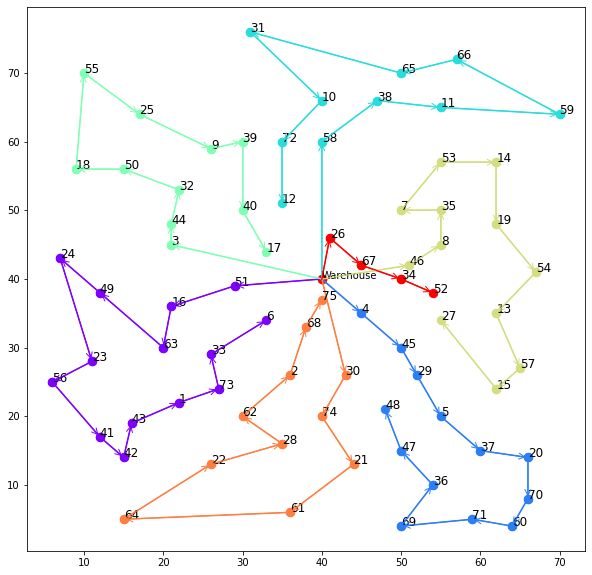

In [38]:
results(result_pulp,corrdinates)

# Approach 2

# Clustering + Travelling sales men problem

In [39]:
(n_customers, Capacity, Distance_Matrix, Distance_Warehouses, Demands,  customers_x, customers_y, depot_x, depot_y) = read_input_sdvrp(inputfilepath)
# (n_customers, Capacity, Distance_Matrix, Distance_Warehouses, Demands, customers_x, customers_y) = Decrease_Problem_size(n_customers, Capacity, Distance_Matrix, Distance_Warehouses, Demands, customers_x, customers_y ,
#                                                                                                Prob_size, new_Capacity)
    
    

df_data=pd.DataFrame([[depot_x]+customers_x, [depot_y]+customers_y, [0]+Demands ]).T

df_data.columns=['X','Y','Demand']
df_data.to_csv('corrdinate_demand_data.csv')

Demands=[0]+Demands
customers_x=[depot_x]+customers_x
customers_y=[depot_y]+customers_y

IdentityDict={}
while max(Demands)>Capacity:
    Max_demand=max(Demands)
    i=Demands.index(max(Demands))
    Demands[i]=Capacity
    Demands.append(Max_demand-Capacity)
    IdentityDict[len(Demands)-1]=i
        

for i in IdentityDict.keys():
    customers_x.append(customers_x[int(IdentityDict[i])])
    customers_y.append(customers_y[int(IdentityDict[i])])
    

Distance_Matrix_ortools = compute_distance_matrix(customers_x, customers_y)
pd.DataFrame(Distance_Matrix_ortools).to_csv('DistanceMatrix.csv')

depot = [0 , depot_x, depot_y, 0]
customers=[[i,customers_x[i],customers_y[i],Demands[i]] for i in range(1,len(Demands))]
customerCount = len(Demands)-1
vehicleCount = int(np.ceil(sum(Demands)/Capacity))
vehicleCapacity = Capacity

k_cluster 7


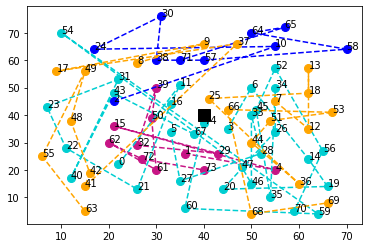

In [40]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# pastebin.com/UwqUrHhh
# output graph: i.imgur.com/u3v2OFt.png

import math
import random
from operator import itemgetter
from copy import deepcopy
import numpy
import pylab


assigned = [-1] * customerCount

# number of clusters
k_cluster = 0
# binary matrix
bin_matrix = []
# coordinate of centroids
centroids = []
# total demand for each cluster, must be <= capacity
tot_demand = []
# members of each cluster
members = []
# coordinate of members of each cluster
xy_members = []

def distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# capacitated k-means clustering
# http://www.dcc.ufla.br/infocomp/artigos/v8.4/art07.pdf
def cap_k_means():
    global k_cluster, bin_matrix, centroids, tot_demand
    global members, xy_members, prev_members

    # calculate number of clusters
    tot_demand = sum([c[3] for c in customers])
    k_cluster = int(math.ceil(float(tot_demand) / vehicleCapacity))
    print('k_cluster', k_cluster)

    # initial centroids = first sorted-customers based on demand
    d_customers = sorted(customers, key=itemgetter(3), reverse=True)
    centroids, tot_demand, members, xy_members = [], [], [], []
    for i in range(k_cluster):
        centroids.append(d_customers[i][1:3])   # [x,y]

        # initial total demand and members for each cluster
        tot_demand.append(0)
        members.append([])
        xy_members.append([])

    # binary matrix, dimension = customerCount-1 x k_cluster
    bin_matrix = [[0] * k_cluster for i in range(len(customers))]

    converged = False
    while not converged:  # until no changes in formed-clusters
        prev_matrix = deepcopy(bin_matrix)

        for i in range(len(customers)):
            edist = []  # list of distance to clusters

            if assigned[i] == -1:  # if not assigned yet
                # Calculate the Euclidean distance to each of k-clusters
                for k in range(k_cluster):
                    p1 = (customers[i][1], customers[i][2]) # x,y
                    p2 = (centroids[k][0], centroids[k][1])
                    edist.append((distance(p1, p2), k))

                # sort, based on closest distance
                edist = sorted(edist, key=itemgetter(0))

            closest_centroid = 0    # first index of edist
            # loop while customer[i] is not assigned
            while assigned[i] == -1:  
                # calculate all unsigned customers (G)'s priority
                max_prior = (0, -1)   # value, index
                for n in range(len(customers)):
                    pc = customers[n]

                    if assigned[n] == -1:   # if unassigned
                        # get index of current centroid
                        c = edist[closest_centroid][1]
                        cen = centroids[c]     # x,y

                        # distance_cost / demand
                        p = distance((pc[1], pc[2]), cen) / pc[3]

                        # find highest priority
                        if p > max_prior[0]:
                            max_prior = (p, n)  # priority,customer-index

                # if highest-priority is not found, what should we do ???
                if max_prior[1] == -1:   
                    break

                # try to assign current cluster to highest-priority customer
                hpc = max_prior[1]    # index of highest-priority customer
                c = edist[closest_centroid][1]   # index of current cluster

                # constraint, total demand in a cluster <= capacity
                if tot_demand[c] + customers[hpc][3] <= vehicleCapacity:
                    # assign new member of cluster
                    members[c].append(hpc)   # add index of customer

                    xy = (customers[hpc][1], customers[hpc][2])  # x,y
                    xy_members[c].append(xy)

                    tot_demand[c] += customers[hpc][3]
                    assigned[hpc] = c   # update cluster to assigned-customer

                    # update binary matrix
                    bin_matrix[hpc][c] = 1

                # if customer is not assigned then,
                if assigned[i] == -1:
                    if closest_centroid < len(edist)-1:
                        # choose the next nearest centroid
                        closest_centroid += 1

                    # if run out of closest centroid, what must we do ???
                    else:
                        break   # exit without centroid ???

            # end while
        # end for

        # Calculate the new centroid from the formed clusters
        for j in range(k_cluster):
            xj = sum([cn[0] for cn in xy_members[j]])
            yj = sum([cn[1] for cn in xy_members[j]])
            xj = float(xj) / len(xy_members[j])
            yj = float(yj) / len(xy_members[j])
            centroids[j] = (xj, yj)

        # calculate converged
        converged = numpy.array_equal(numpy.array(prev_matrix), numpy.array(bin_matrix))
    # end while

def clustering():
    cap_k_means()

    # debug plot
    idx = numpy.array([c for c in assigned])
    xy = numpy.array([(c[1], c[2]) for c in customers])

    COLORS = ["Blue", "DarkSeaGreen", "DarkTurquoise", 
          "IndianRed", "MediumVioletRed", "Orange", "Purple"]

    for i in range(min(idx), max(idx)+1):
        clr = random.choice(COLORS)
        pylab.plot(xy[idx==i, 0], xy[idx==i, 1], color=clr, \
            linestyle='dashed', \
            marker='o', markerfacecolor=clr, markersize=8)
#     pylab.plot(centroids[:][0], centroids[:][1], '*k', markersize=12)
    pylab.plot(depot[1], depot[2], 'sk', markersize=12)

    for i in range(len(idx)):
        pylab.annotate(str(i), xy[i])

#     pylab.savefig('clust1.png')
    pylab.show()

    return idx

idx = clustering()
# print('idx', idx)
# print('centroids', centroids)
members = [[i+1 for i in j] for j in members]
# print('members', members)
# print('demands', tot_demand)



In [41]:
vehicle_wise_Data={}
for k in range(1,len(members)+1):
    
    vehicle_wise_Data[k]={}
    vehicle_wise_Data[k]['members']=[0]+members[k-1]
    vehicle_wise_Data[k]['Dist_Matrix'] = [[Distance_Matrix_ortools[i][j] for i in [0]+members[k-1]] for j in [0]+members[k-1]]
    vehicle_wise_Data[k]['Demand'] = [0]+[Demands[i] for i in members[k-1]]


In [42]:
"""Simple Travelling Salesperson Problem (TSP) between cities."""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model(k):
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = vehicle_wise_Data[k]['Dist_Matrix']
    data['num_vehicles'] = 1
    data['depot'] = 0
    return data


def print_solution(manager, routing, solution):
    """Prints solution on console."""
#     print('Objective: {} miles'.format(solution.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = 'Route for vehicle 0:\n'
    route_distance = 0
    route=[]
    while not routing.IsEnd(index):
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        previous_index = index
        route.append(index)
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
#     print(plan_output)
#     print('route_For_Vehicle',k)
#     print([vehicle_wise_Data[k]['members'][i] for i in route]+[0])
#     print([vehicle_wise_Data[k]['Demand'][i] for i in route]+[0])
    plan_output += 'Route distance: {}miles\n'.format(route_distance)
    return [vehicle_wise_Data[k]['members'][i] for i in route]+[0], [vehicle_wise_Data[k]['Demand'][i] for i in route]+[0]

def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]



In [43]:
objective=0
result_Routes={}

for k in range(1,len(members)+1):
    result_Routes[k]={}
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model(k)
    
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)




    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)
    objective += solution.ObjectiveValue()
    # Print solution on console.
    if solution:
        result_Routes[k]['route'],result_Routes[k]['Demand']=print_solution(manager, routing, solution)


In [44]:
objective

1034

In [45]:
Result_Arcs = []
for k in result_Routes.keys():
    route=result_Routes[k]['route']
    demand=result_Routes[k]['Demand']
    for i in range(len(route)-1):
        Result_Arcs.append([k,route[i],route[i+1],demand[i+1]])

In [46]:
pd.DataFrame(Result_Arcs,columns=['Vehicle','start','end','Demand']).to_csv('Result_ortools_clustering.csv')

In [47]:
corrdinates     = pd.read_csv("corrdinate_demand_data.csv")
result_clusters  = pd.read_csv("Result_ortools_clustering.csv")

corrdinates.columns = ['Store', 'X', 'Y', 'Demand']

Route for truck  1  is:
0 --> 30(22) -->  5(21) -->  74(10) -->  2(26) -->  62(18) -->  73(6) -->  33(27) -->  63(11) -->  16(19) -->  51(12) -->  40(33) -->  0

Route for truck  2  is:
0 --> 75(20) -->  34(19) -->  29(13) -->  48(20) -->  47(19) -->  60(13) -->  61(15) -->  28(29) -->  6(19) -->  55(7) -->  0

Route for truck  3  is:
0 --> 4(30) -->  21(28) -->  36(12) -->  71(3) -->  20(22) -->  15(8) -->  57(14) -->  27(17) -->  46(27) -->  35(10) -->  53(22) -->  7(15) -->  0

Route for truck  4  is:
0 --> 68(10) -->  1(18) -->  22(12) -->  41(15) -->  23(6) -->  24(27) -->  44(17) -->  32(28) -->  12(16) -->  17(20) -->  0

Route for truck  5  is:
0 --> 3(11) -->  25(14) -->  31(25) -->  65(9) -->  66(37) -->  59(24) -->  11(37) -->  58(21) -->  72(1) -->  39(16) -->  0

Route for truck  6  is:
0 --> 43(18) -->  42(11) -->  64(28) -->  56(26) -->  49(5) -->  18(13) -->  50(22) -->  9(29) -->  10(26) -->  38(24) -->  0

Route for truck  7  is:
0 --> 26(18) -->  67(30) -->  8(16) --

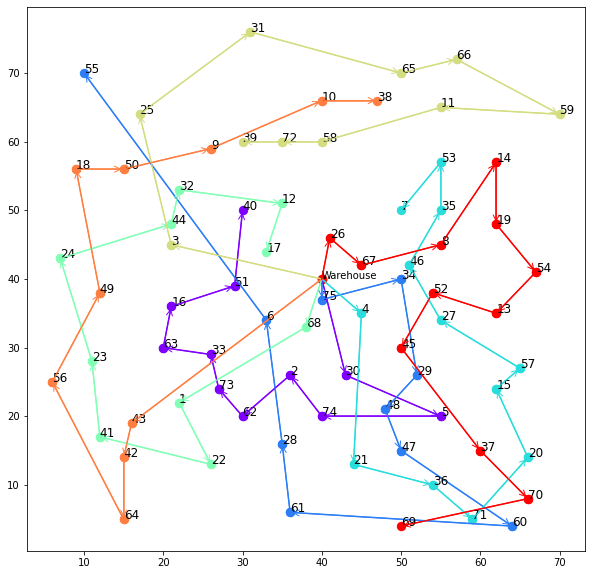

In [48]:
results(result_clusters,corrdinates)

# KPI calculations

In [49]:
truck_capacity = Capacity
cutoff = 0.95

In [50]:
Distance = pd.read_csv("DistanceMatrix.csv")
Distance = Distance.rename(columns = {'Unnamed: 0' : 'Store'})
#Distance = Distance.drop(columns = {'Unnamed: 0'})

In [51]:
new = pd.DataFrame(index=range(len(Distance)*len(Distance)),columns=['Key','Distance'])
x = 0
for i in range(0,len(Distance)):
    for j in range(0,len(Distance)):
        new['Key'][x] = str(i) + "_" + str(j)
        new['Distance'][x] = Distance.iloc[i,j+1]
        x = x + 1

In [52]:
store_inf = pd.read_csv("corrdinate_demand_data.csv")
store_inf = store_inf.drop(columns = {'Unnamed: 0'})
#store_inf = store_inf.rename(columns = {'Unnamed: 0' : 'Store'})

In [53]:
def final(abc):

    abc = abc.drop(columns = {'Unnamed: 0'})
    abc['Key'] = '0'
    for i in range(0,len(abc)):
        abc['Key'][i] = str(abc['start'][i]) + "_" + str(abc['end'][i])
    abc = pd.merge(abc,new,on=['Key'],how ='left')
    
    tot_route_length = abc['Distance'].sum()
    avg_route_length = tot_route_length/abc['Vehicle'].nunique()
    veh_route_length = abc.groupby(['Vehicle'])['Distance'].sum()
    min_route_length = veh_route_length.min()
    max_route_length = veh_route_length.max()
    tot_demand = abc['Demand'].sum()
    avg_demand = tot_demand/abc['Vehicle'].nunique()
    veh_demand = abc.groupby(['Vehicle'])['Demand'].sum()
    veh_utilisation = veh_demand/truck_capacity
    avg_utilisation = tot_demand/(truck_capacity*abc['Vehicle'].nunique())
    median_utilisation = veh_utilisation.median()
    min_utilisation = veh_utilisation.min()
    max_utilisation = veh_utilisation.max()
    best_utilisation_prop =(veh_utilisation > cutoff).sum()/veh_utilisation.count()
    store_cnt_veh = abc.groupby(['Vehicle'])['Key'].count() - 1
    store_cnt_avg = store_cnt_veh.sum()/abc['Vehicle'].nunique()
    store_cnt_median = store_cnt_veh.median()
    store_cnt_min = store_cnt_veh.min()
    store_cnt_max = store_cnt_veh.max()
    
    data = [['total_route_length', tot_route_length], ['average_route_length', avg_route_length],
           ['min_route_length', min_route_length], ['max_route_length', max_route_length],
           ['median_utilisation', median_utilisation], ['min_utilisation', min_utilisation],
           ['max_utilisation', max_utilisation], ['no_of_truck_utilisation', best_utilisation_prop],
           ['median_stores_per_route', store_cnt_median], ['min_store_route', store_cnt_min],
           ['max_store_route', store_cnt_max]]
    df = pd.DataFrame(data, columns = ['KPI', 'Algo'])
    return df

In [54]:
outp_1 = pd.read_csv("Result_ortools_pulp_warmstart.csv")
outp_2 = pd.read_csv("Result_ortools_clustering.csv")

In [55]:
exc_1 = final(outp_1)
exc_2 = final(outp_2)
#exc_3 = final(outp_3)

In [56]:
final_kpi = pd.merge(exc_1,exc_2,on=['KPI'],how ='inner')

In [57]:
final_kpi

,KPI,Algo_x,Algo_y
0,total_route_length,721.890000,1063.590000
1,average_route_length,103.127143,151.941429
2,min_route_length,35.740000,114.430000
3,max_route_length,137.110000,199.480000
4,median_utilisation,0.954545,0.918182
5,min_utilisation,0.390909,0.768182
6,max_utilisation,1.000000,0.959091
7,no_of_truck_utilisation,0.571429,0.142857
8,median_stores_per_route,11.000000,10.000000
9,min_store_route,4.000000,10.000000


In [58]:
final_kpi.to_csv('KPI_VRP_v2.csv')